# Overview 

Nairobi Hospital conducted a clinical camp to test for hypothyroidism. The data collected focused on Thyroid patients. Use the healthcare datasets provided to accomplish the following:  

**Build a model that determines whether or not the patient's symptoms indicate that the patient has hypothyroid.**

# Part 1: Decision trees:
- For this section, you should build a model that makes the above prediction. You should not use individual decision trees, rather you should use at least 2 out of the 3 advanced models we have studied: Random forests, Ada boosted trees, and gradient boosted trees.
- Try and optimize each of the 2 models, making sure to document how you've set up your hyperparameters.
- Identify which of the 2 models you trust most, and use your model to determine which features are most impactful in influencing the prediction
- Note that with decision trees, you don't need to do a lot of data cleaning. This will be very different with SVM.

# Part 2: SVM:

- In this section, you may be required to clean the data a little bit so as to make sense of the features.

- Document what transformation you've done on the data.

- Apply Polynomial, linear and rbf kernel function to build your SVM model and then evaluate their performance and pick the kernel that performs the best. Remember to tune your parameters to improve the performance of your model. To make your life easier, make sure to visualize the models you've created. Use any two features to build the models for this step.

In [90]:
#Initial Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(font_scale=1.2)
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score

In [91]:
#Mounting notepad to drive for data reading or add it to the current runtime
df = pd.read_csv('/content/hypothyroid.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3163 entries, 0 to 3162
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   status                     3163 non-null   object
 1   age                        3163 non-null   object
 2   sex                        3163 non-null   object
 3   on_thyroxine               3163 non-null   object
 4   query_on_thyroxine         3163 non-null   object
 5   on_antithyroid_medication  3163 non-null   object
 6   thyroid_surgery            3163 non-null   object
 7   query_hypothyroid          3163 non-null   object
 8   query_hyperthyroid         3163 non-null   object
 9   pregnant                   3163 non-null   object
 10  sick                       3163 non-null   object
 11  tumor                      3163 non-null   object
 12  lithium                    3163 non-null   object
 13  goitre                     3163 non-null   object
 14  TSH_meas

In [92]:
df.head(5)

,status,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,thyroid_surgery,query_hypothyroid,query_hyperthyroid,pregnant,sick,tumor,lithium,goitre,TSH_measured,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG
0,hypothyroid,72,M,f,f,f,f,f,f,f,f,f,f,f,y,30,y,0.60,y,15,y,1.48,y,10,n,?
1,hypothyroid,15,F,t,f,f,f,f,f,f,f,f,f,f,y,145,y,1.70,y,19,y,1.13,y,17,n,?
2,hypothyroid,24,M,f,f,f,f,f,f,f,f,f,f,f,y,0,y,0.20,y,4,y,1,y,0,n,?
3,hypothyroid,24,F,f,f,f,f,f,f,f,f,f,f,f,y,430,y,0.40,y,6,y,1.04,y,6,n,?
4,hypothyroid,77,M,f,f,f,f,f,f,f,f,f,f,f,y,7.30,y,1.20,y,57,y,1.28,y,44,n,?


In [93]:
#The two dependent states the patient can be in
df['status'].unique()
(df['status'] == 'hypothyroid').sum()
(df['status'] != 'hypothyroid').sum()

3012

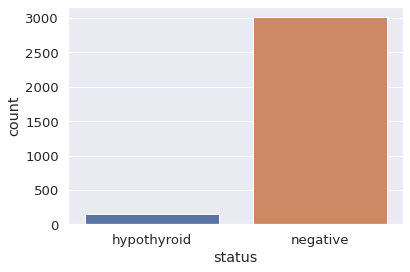

In [94]:
sns.countplot(x=df['status'], data = df)
#More people in this dataset are negative for the virus(302)

In [95]:
#Lets check the data for any issus
(df.duplicated() == True).sum()
#i wont remove these as i dont know if its the same patient or through coincidence all the readings were the same

77

In [96]:
df.describe()

,status,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,thyroid_surgery,query_hypothyroid,query_hyperthyroid,pregnant,sick,tumor,lithium,goitre,TSH_measured,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG
count,3163,3163,3163,3163,3163,3163,3163,3163,3163,3163,3163,3163,3163,3163,3163,3163,3163,3163,3163,3163,3163,3163,3163,3163,3163,3163
unique,2,93,3,2,2,2,2,2,2,2,2,2,2,2,2,240,2,70,2,269,2,159,2,281,2,53
top,negative,?,F,f,f,f,f,f,f,f,f,f,f,f,y,0,y,?,y,?,y,?,y,?,n,?
freq,3012,446,2182,2702,3108,3121,3059,2922,2920,3100,3064,3123,3161,3064,2695,894,2468,695,2914,249,2915,248,2916,247,2903,2903


In [97]:
df.head(1)

,status,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,thyroid_surgery,query_hypothyroid,query_hyperthyroid,pregnant,sick,tumor,lithium,goitre,TSH_measured,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG
0,hypothyroid,72,M,f,f,f,f,f,f,f,f,f,f,f,y,30,y,0.60,y,15,y,1.48,y,10,n,?


In [98]:
#Next step is to take just a slice of the frame to work on
sick = df[['status','sex', 'age', 'on_thyroxine','on_antithyroid_medication','thyroid_surgery','query_on_thyroxine','query_hyperthyroid','pregnant','sick','tumor','lithium','goitre','TSH','T3','TT4','T4U','FTI','TBG']]
sick.info()
#Dropping the others are they wont help

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3163 entries, 0 to 3162
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   status                     3163 non-null   object
 1   sex                        3163 non-null   object
 2   age                        3163 non-null   object
 3   on_thyroxine               3163 non-null   object
 4   on_antithyroid_medication  3163 non-null   object
 5   thyroid_surgery            3163 non-null   object
 6   query_on_thyroxine         3163 non-null   object
 7   query_hyperthyroid         3163 non-null   object
 8   pregnant                   3163 non-null   object
 9   sick                       3163 non-null   object
 10  tumor                      3163 non-null   object
 11  lithium                    3163 non-null   object
 12  goitre                     3163 non-null   object
 13  TSH                        3163 non-null   object
 14  T3      

# 1. Time for exploration and cleaning 

In [99]:
#First step will be to deal with nulls and do some label encoding

In [100]:
sick.head()

,status,sex,age,on_thyroxine,on_antithyroid_medication,thyroid_surgery,query_on_thyroxine,query_hyperthyroid,pregnant,sick,tumor,lithium,goitre,TSH,T3,TT4,T4U,FTI,TBG
0,hypothyroid,M,72,f,f,f,f,f,f,f,f,f,f,30,0.60,15,1.48,10,?
1,hypothyroid,F,15,t,f,f,f,f,f,f,f,f,f,145,1.70,19,1.13,17,?
2,hypothyroid,M,24,f,f,f,f,f,f,f,f,f,f,0,0.20,4,1,0,?
3,hypothyroid,F,24,f,f,f,f,f,f,f,f,f,f,430,0.40,6,1.04,6,?
4,hypothyroid,M,77,f,f,f,f,f,f,f,f,f,f,7.30,1.20,57,1.28,44,?


In [101]:
from sklearn.preprocessing import LabelEncoder

label = LabelEncoder()

In [102]:
#Perfroming encoding for the catergorical values

sick['status'] = label.fit_transform(sick['status'])
sick['on_thyroxine'] = label.fit_transform(sick['on_thyroxine'])
sick['query_on_thyroxine'] = label.fit_transform(sick['query_on_thyroxine'])
sick['on_antithyroid_medication'] = label.fit_transform(sick['on_antithyroid_medication'])
sick['thyroid_surgery'] = label.fit_transform(sick['thyroid_surgery'])
sick['query_hyperthyroid'] = label.fit_transform(sick['query_hyperthyroid'])
sick['sick'] = label.fit_transform(sick['sick'])
sick['tumor'] = label.fit_transform(sick['tumor'])
sick['lithium'] = label.fit_transform(sick['lithium'])
sick['goitre'] = label.fit_transform(sick['goitre'])
sick['pregnant'] = label.fit_transform(sick['pregnant'])
sick['sex'] = label.fit_transform(sick['sex'])
sick.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

,status,sex,age,on_thyroxine,on_antithyroid_medication,thyroid_surgery,query_on_thyroxine,query_hyperthyroid,pregnant,sick,tumor,lithium,goitre,TSH,T3,TT4,T4U,FTI,TBG
0,0,2,72,0,0,0,0,0,0,0,0,0,0,30,0.60,15,1.48,10,?
1,0,1,15,1,0,0,0,0,0,0,0,0,0,145,1.70,19,1.13,17,?
2,0,2,24,0,0,0,0,0,0,0,0,0,0,0,0.20,4,1,0,?
3,0,1,24,0,0,0,0,0,0,0,0,0,0,430,0.40,6,1.04,6,?
4,0,2,77,0,0,0,0,0,0,0,0,0,0,7.30,1.20,57,1.28,44,?


In [103]:
#Replacing the ? in the TBG column with 0

sick['TBG'] = np.where((sick.TBG == '?'), 0, sick.TBG)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [104]:
sick['TBG'].unique()

array([0, '28', '34', '0', '19', '30', '25', '48', '39', '31', '16', '21',
       '37', '40', '27', '3.10', '38', '108', '20', '36', '17', '23',
       '35', '32', '63', '9.30', '15', '26', '33', '41', '110', '22',
       '43', '53', '80', '47', '29', '13', '24', '18', '45', '86', '50',
       '8.40', '52', '11', '12', '14', '65', '7.30', '8.50', '69', '122'],
      dtype=object)

In [105]:
sick.head(6)
cors = sick.corr()

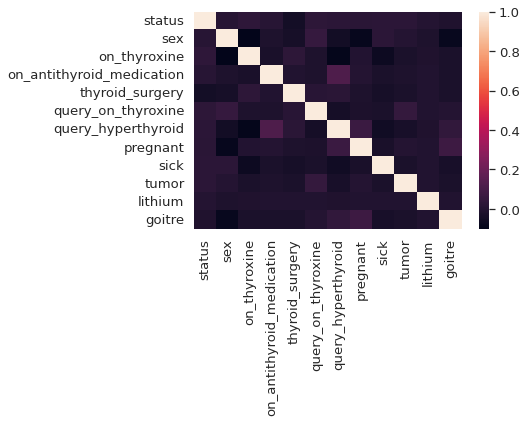

In [106]:
sns.heatmap(cors)
#Not much ca be assumed from the heatmap

In [107]:
# converting a slice of the dataframe does not help us in selecting which variables to use. We will use this cleaned up slice for regression if need be

# Time to begin modeling
# We will begin by using a vanilla random forest

In [108]:
# Import the model
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


In [109]:
y = sick['status'].values

test_features = ['sex','pregnant','sick','tumor','on_thyroxine','on_antithyroid_medication','lithium','goitre']
X = sick[test_features].values

# Train using 80% of the data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [110]:
sick.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3163 entries, 0 to 3162
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   status                     3163 non-null   int64 
 1   sex                        3163 non-null   int64 
 2   age                        3163 non-null   object
 3   on_thyroxine               3163 non-null   int64 
 4   on_antithyroid_medication  3163 non-null   int64 
 5   thyroid_surgery            3163 non-null   int64 
 6   query_on_thyroxine         3163 non-null   int64 
 7   query_hyperthyroid         3163 non-null   int64 
 8   pregnant                   3163 non-null   int64 
 9   sick                       3163 non-null   int64 
 10  tumor                      3163 non-null   int64 
 11  lithium                    3163 non-null   int64 
 12  goitre                     3163 non-null   int64 
 13  TSH                        3163 non-null   object
 14  T3      

In [111]:
forest = RandomForestRegressor(n_estimators = 100, random_state=42, min_samples_split = 20, max_depth=50)
forest = forest.fit(X_train, y_train)

# Predict based on the model we've trained
y_pred = forest.predict(X_test)


In [112]:
comparison_frame = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})

comparison_frame.describe()

,Actual,Predicted
count,949.000000,949.000000
mean,0.958904,0.950353
std,0.198617,0.020403
min,0.000000,0.931920
25%,1.000000,0.932729
50%,1.000000,0.940809
75%,1.000000,0.959554
max,1.000000,1.000000


In [113]:
from sklearn import metrics

# And now we assess the errors
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.08674398659149415
Mean Squared Error: 0.03997769051781516
Root Mean Squared Error: 0.1999442185156029


Time for some visuals

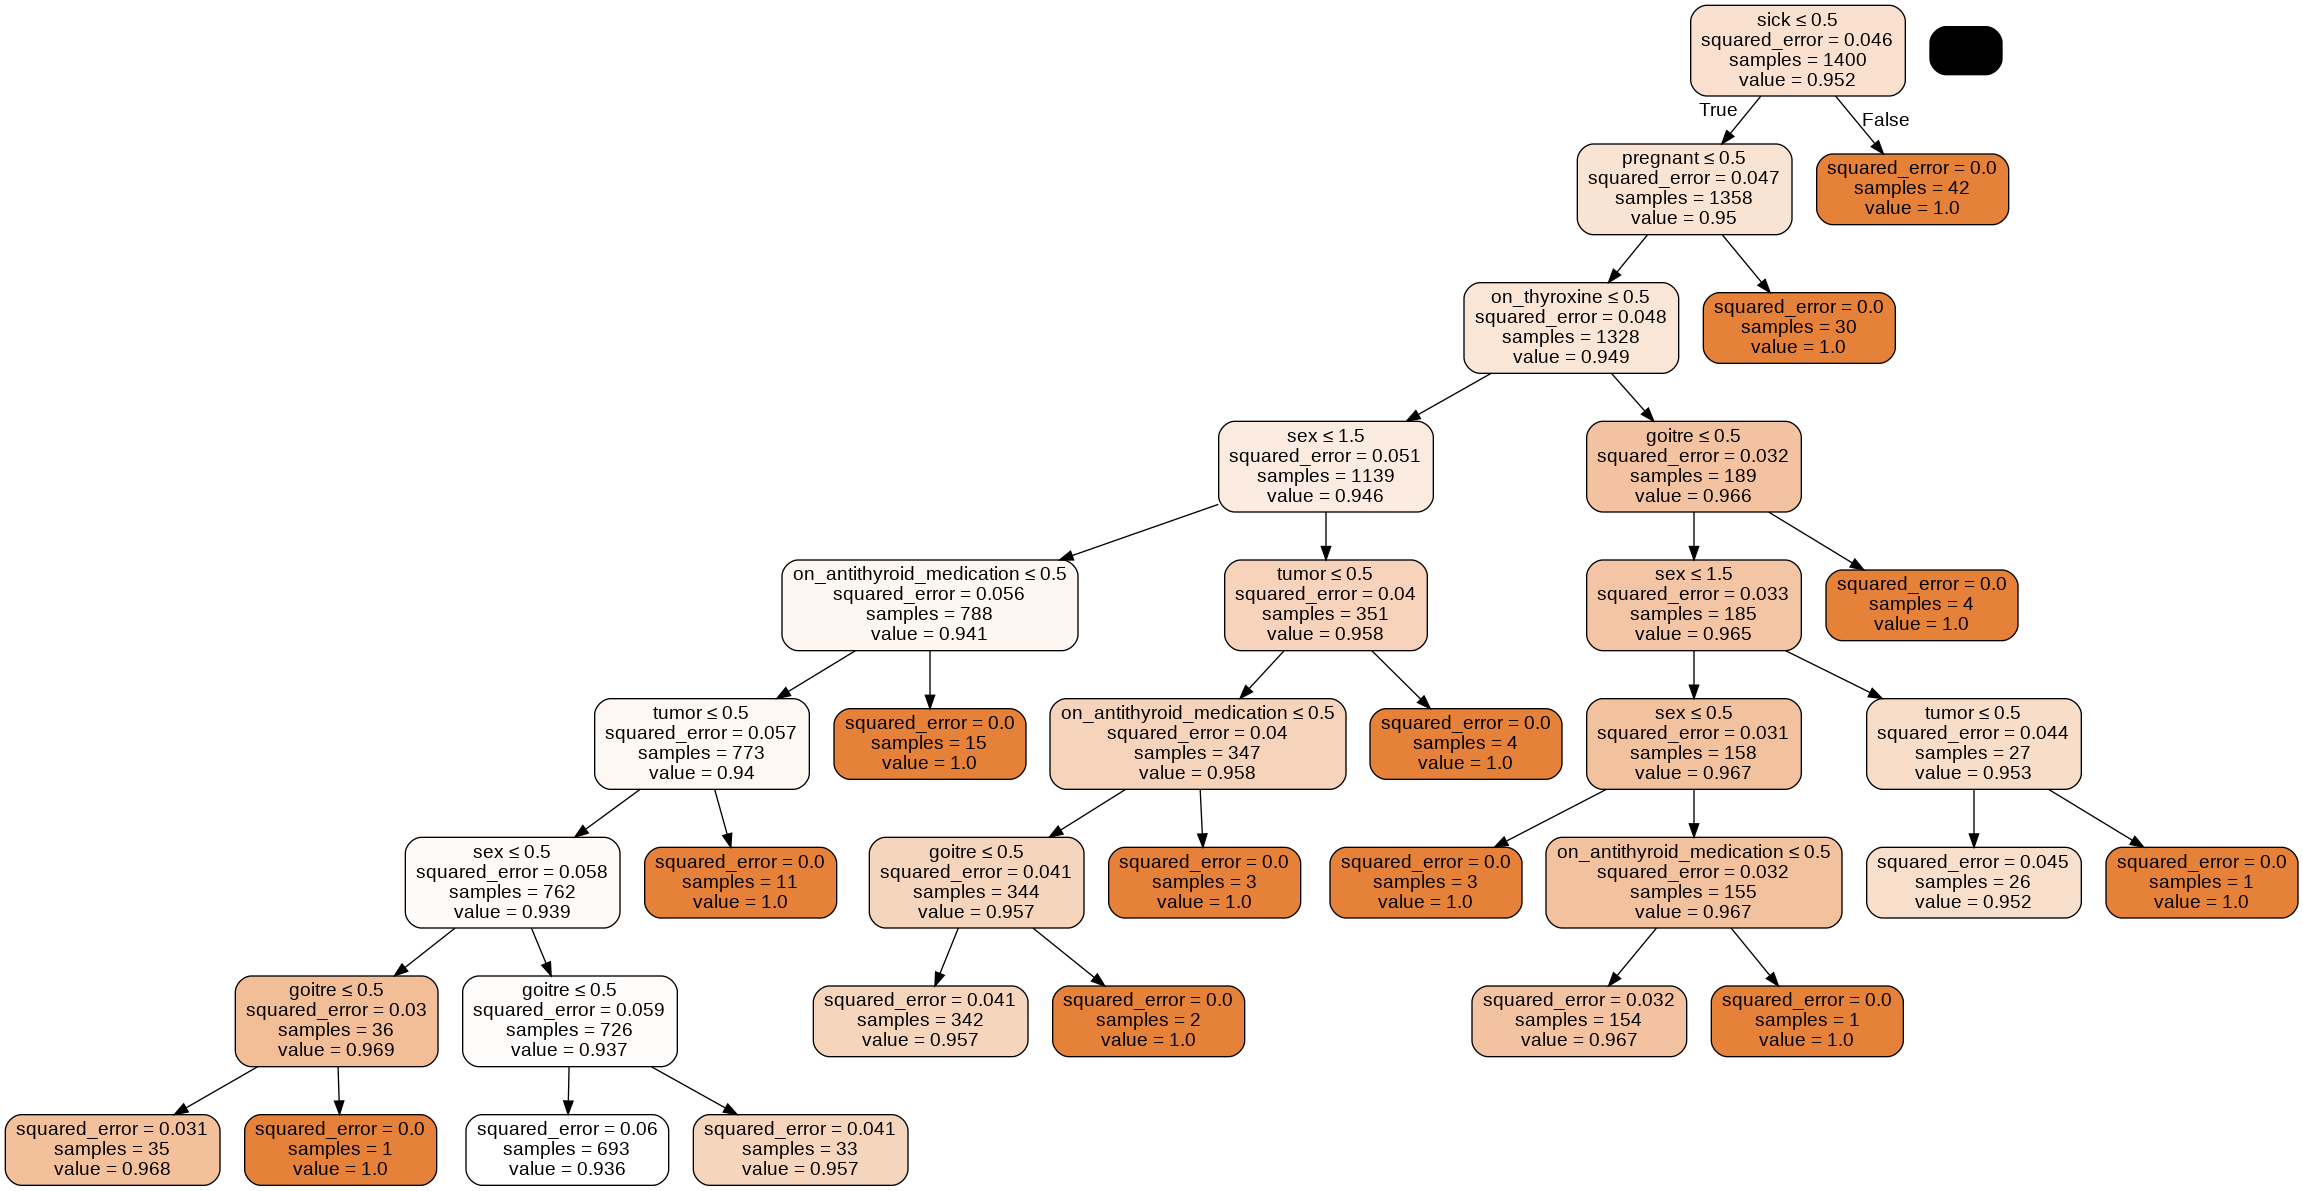

In [114]:
from sklearn.tree import export_graphviz
from io import StringIO  
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
# pick a specific tree from the forest
tree = forest.estimators_[50]

export_graphviz(tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = test_features)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('absenteism_forest.png')
Image(graph.create_png())

In [115]:
#The dataset is not so large so i will attempt gradeint boosting to try improve the accuracy
from sklearn.ensemble import GradientBoostingRegressor
target_number_of_trees = 30000

In [116]:
#Training and testing
gbr = GradientBoostingRegressor(n_estimators=target_number_of_trees, learning_rate=2, max_depth=2)
gbr = gbr.fit(X_train, y_train)

y_pred_gbr = gbr.predict(X_test)

In [117]:
# And now we assess the errors
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_gbr))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_gbr))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_gbr)))

Mean Absolute Error: 0.09040745314872234
Mean Squared Error: 0.04078945300989836
Root Mean Squared Error: 0.20196398938894616


Even a large increase in the number of trees is the gradient boost model did not change or improve the accuracy of the model. Unsure why, playing around with the conditions does not affect anything. However the learning rate of 2 seemed to have a postive impact

Mean Absolute Error: 0.09040745314872123
Mean Squared Error: 0.040789453009898315
Root Mean Squared Error: 0.20196398938894605

# Onto the 2nd model Support vector machines


Same as before vanilla version then we get spicy

In [118]:
from sklearn.svm import SVC,LinearSVC
# Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import  accuracy_score


In [119]:
#I will go with the top 3 variables i think would have the most impact in this model
variables = sick[['sex','on_antithyroid_medication','thyroid_surgery']]
choice = sick['status']

#Fitting
modelS = SVC(kernel='linear')
modelS.fit(variables, choice)

SVC(kernel='linear')

In [120]:
X_train, X_test, y_train, y_test = train_test_split(variables, choice, test_size = 0.2, random_state = 0)
y_pred = modelS.predict(X_test)

In [121]:
# Checking the accurancy of the model
model_accuracy = accuracy_score(y_test,y_pred)
model_accuracy


0.9589257503949447

In [122]:
#The above accuracy is quite high which is good and bad, it might mean the model has overfit making it useless for other datasights
#Lets try other types of SVM models

In [123]:
#Fitting
modelP = SVC(kernel='poly')
modelP.fit(variables, choice)

SVC(kernel='poly')

In [124]:
y_pred = modelP.predict(X_test)

In [125]:
model_accuracy = accuracy_score(y_test,y_pred)
model_accuracy

0.9589257503949447

Finally the rbf kernel one

In [126]:
model = SVC()
model.fit(variables, choice)

SVC()

In [127]:
y_pred = model.predict(X_test)

In [128]:
model_accuracy = accuracy_score(y_test,y_pred)
model_accuracy

0.9589257503949447

In a interesting turn of events all the different kernel types lead to having the same model accuracy of around 96%. As we only have 3k rows i will accept this accuracy as useful for now but will require more 'training' to fit a new dataset as well

In [129]:
#Ignore below, trying out a few other things

In [130]:
#Attempting hypertuning of parameters for the random forest

In [131]:
# Scaling our Data
# ---
# 
from sklearn.preprocessing import StandardScaler
feature_scaler = StandardScaler()

In [134]:
y = sick['status'].values

test_features = ['sex','pregnant','sick','tumor','on_thyroxine','on_antithyroid_medication','lithium','goitre']
X = sick[test_features].values



# Train using 80% of the data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [135]:
X_train = feature_scaler.fit_transform(X_train)
X_test = feature_scaler.transform(X_test)

In [136]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=300, random_state=0,min_samples_split = 20, max_depth=50)

In [137]:
from sklearn.model_selection import cross_val_score
all_accuracies = cross_val_score(estimator=classifier, X=X_train, y=y_train, cv=5)

In [138]:
print(all_accuracies.mean())

0.949413194692706


In [139]:
#Pretty good level of accuracy, trying out Grid Search
grid_param = {
    'n_estimators': [100, 300, 500, 800, 1000],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False]
}

In [140]:
from sklearn.model_selection import GridSearchCV
gd_sr = GridSearchCV(estimator=classifier,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [141]:
gd_sr.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=50,
                                              min_samples_split=20,
                                              n_estimators=300,
                                              random_state=0),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'n_estimators': [100, 300, 500, 800, 1000]},
             scoring='accuracy')

In [142]:
best_parameters = gd_sr.best_params_
print(best_parameters)

{'bootstrap': True, 'criterion': 'gini', 'n_estimators': 100}


In [143]:
best_result = gd_sr.best_score_
print(best_result)

0.949413194692706


In [144]:
#The feature selection processes still net a smiliar level of accuracy, no improvement noticed from the variables selected

In [145]:
# Creating regularization penalty space
penalty = ['l1', 'l2']

# Creating regularization hyperparameter space
C = [1, 10, 100,100]

# Creating hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

In [146]:
# Creating grid search using 5-fold cross validation
clf = GridSearchCV(classifier, hyperparameters, cv=5, verbose=0)

In [147]:
# Fitting grid search
best_model = clf.fit(X_train, y_train)

ValueError: ignored

In [ ]:
# Viewing best hyperparameters
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

In [ ]:
best_model.predict(X_test)

In [153]:
y = sick['status'].values

test_features = ['sex','pregnant','sick','tumor','on_thyroxine','on_antithyroid_medication','lithium','goitre']
X = sick[test_features].values

#X = sick.drop(['status'], axis = 1)

# Train using 80% of the data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [154]:
rfc=RandomForestClassifier(random_state=42)

In [158]:
param_grid = { 
    'n_estimators': [30 ,200, 500, 1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8,10,15,20],
    'criterion' :['gini', 'entropy']
}

In [159]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8, 10, 15, 20],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [30, 200, 500, 1000]})

In [160]:
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 4,
 'max_features': 'auto',
 'n_estimators': 30}

In [161]:
newRF = RandomForestClassifier(random_state= 42, max_features= 'auto',n_estimators= 30, max_depth=4, criterion= 'gini')
newRF.fit(X_train,y_train)

RandomForestClassifier(max_depth=4, n_estimators=30, random_state=42)

In [162]:
pred = newRF.predict(X_test)

In [163]:
accuracy_score(y_test,pred)

0.958904109589041

In [ ]:
#No difference in the accuracy 